In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
plt.rcParams['svg.fonttype'] = 'none'

# Data preparation and overview

In [3]:
## Load all data
## Load metadata
os.chdir('/home/alexcc/song_collaboration/bgc_tran')

mibig_metadata = pd.read_csv('./data/metadata/mibig2_metadata.tsv', sep="\t")

In [4]:
#data fixes
m = mibig_metadata
m.loc[m['Type'] == 'lantipeptide', 'Type'] = 'Lanthipeptide'
m.loc[m['Type'] == 'Lantipeptide', 'Type'] = 'Lanthipeptide'
m.Name = [x.lower() for x in m.Name]
f = open('./data/labels/extra_antibiotics')
extra_antibiotics = [x.strip() for x in f.readlines()]
f.close()
f = open('./data/labels/extra_antifungal')
extra_antifungals = [x.strip() for x in f.readlines()]
f.close()
f = open('./data/labels/extra_siderophore')
extra_siderophores = [x.strip() for x in f.readlines()]
f.close()


m.loc[m['Name'].isin(extra_antibiotics), 'Antibacterial'] = 1
m.loc[m['Name'].isin(extra_antifungals), 'Antifungal'] = 1
m.loc[m['Name'].isin(extra_siderophores), 'Siderophore'] = 1
mibig_metadata = m

In [28]:
# Load CATHDB and tcdb metadata
cathdbs = pd.read_csv('./data/metadata/final_fun_families.tsv', sep="\t")
tcdb = pd.read_csv('./data/metadata/tcdb_families.tsv', sep="\t")

In [110]:
# Load mibig data
mibig_pfam = pd.read_csv('./data/pfam/mibig_pfam20.tsv', sep="\t").dropna(how='all', axis='columns')
mibig_cathdb = pd.read_csv('./data/cathdb/mibig_cathdb.tsv', sep="\t").dropna(how='all', axis='columns')
mibig_cathdb = mibig_cathdb[['BGC'] + list(cathdbs['FunFam'])]

mibig_pfam['ABC2_membrane_3'] = mibig_pfam['ABC2_membrane_3'] + mibig_pfam['ABC2_membrane_3.1']
del mibig_pfam['ABC2_membrane_3.1']
# del mibig_cathdb['FunFam']

In [30]:
## General breakdowns

print(str(round(mibig_pfam.shape[0] / float(mibig_metadata.shape[0]) * 100,1)) + "% of MiBIG BGCs have a PFAM transporter")
print(str(round(mibig_cathdb.shape[0] / float(mibig_metadata.shape[0]) * 100,1)) + "% of MiBIG BGCs have a CATHDB transporter")

55.3% of MiBIG BGCs have a PFAM transporter
59.8% of MiBIG BGCs have a CATHDB transporter


In [31]:
## Functional breakdown
## compare G+ and G- antibiotics (PFAM, CATHDB)
abx_plus_data = mibig_metadata[(mibig_metadata.Gram == 1) & (mibig_metadata.Antibacterial == 1)]
abx_plus = mibig_pfam[mibig_pfam.BGC.isin(abx_plus_data.BGC)]

abx_neg_data = mibig_metadata[(mibig_metadata.Gram == 0) & (mibig_metadata.Antibacterial == 1)]
abx_neg = mibig_pfam[mibig_pfam.BGC.isin(abx_neg_data.BGC)]

print(str(abx_plus.shape[0]) + " Gram+ Antibiotic BGCs")
print(str(abx_neg.shape[0]) + " Gram- Antibiotic BGCs")

## compare G+ and G- siderophores (PFAM, CATHDB)
siderophore_plus_data = mibig_metadata[(mibig_metadata.Gram == 1) & (mibig_metadata.Siderophore == 1)]
siderophore_plus = mibig_pfam[mibig_pfam.BGC.isin(siderophore_plus_data.BGC)]

siderophore_neg_data = mibig_metadata[(mibig_metadata.Gram == 0) & (mibig_metadata.Siderophore == 1)]
siderophore_neg = mibig_pfam[mibig_pfam.BGC.isin(siderophore_neg_data.BGC)]

print(str(siderophore_plus.shape[0]) + " Gram+ Siderophore BGCs")
print(str(siderophore_neg.shape[0]) + " Gram- Siderophore BGCs")


133 Gram+ Antibiotic BGCs
22 Gram- Antibiotic BGCs
13 Gram+ Siderophore BGCs
25 Gram- Siderophore BGCs


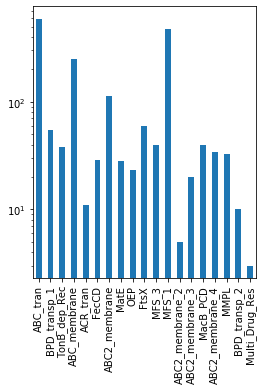

In [32]:
## General plot
total_abund = mibig_pfam.astype(bool).sum()[1:-1]
total_abund.plot.bar()
# plt.ylim(0,1)
plt.yscale('log')
plt.savefig("Fig1c.svg")

plt.show()


# Siderophore vs Antibiotics

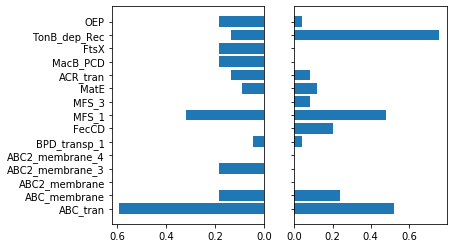

In [36]:
cols = ['ABC_tran', 'ABC_membrane', 'ABC2_membrane', 'ABC2_membrane_3', 'ABC2_membrane_4',
  'BPD_transp_1', 'FecCD', 'MFS_1', 'MFS_3', 'MatE', 'ACR_tran', 'MacB_PCD', 'FtsX', 'TonB_dep_Rec', 'OEP']

plt.rcParams["figure.figsize"] = (6,4)

fig, axes = plt.subplots(ncols=2, sharey=True)
axes[0].barh(abx_neg.sum()[cols].keys(), abx_neg.astype(bool).sum()[cols] / abx_neg.shape[0], align='center')
axes[1].barh(siderophore_neg.sum()[cols].keys(), siderophore_neg.astype(bool).sum()[cols] / siderophore_neg.shape[0], align='center')
axes[0].invert_xaxis()
plt.savefig("Fig2a.svg")

plt.show()

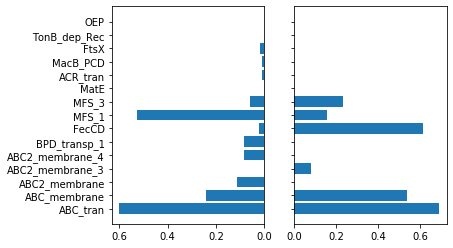

In [37]:
fig, axes = plt.subplots(ncols=2, sharey=True)
axes[0].barh(abx_plus.sum()[cols].keys(), abx_plus.astype(bool).sum()[cols] / abx_plus.shape[0], align='center')
axes[1].barh(siderophore_plus.sum()[cols].keys(), siderophore_plus.astype(bool).sum()[cols] / siderophore_plus.shape[0], align='center')
axes[0].invert_xaxis()
plt.savefig("Fig2b.svg")

plt.show()

## Formatted for ML here

In [111]:
## See a couple sections below on substrate binding protein data too - could bring that in too.

In [101]:
### Siderophore vs Antibiotic for Gram+ PFAMS
pfam_gram_plus = mibig_pfam.copy()
pfam_gram_plus.loc[pfam_gram_plus.BGC.isin(siderophore_plus_data.BGC), 'sid0_vs_abx1'] = 0
pfam_gram_plus.loc[pfam_gram_plus.BGC.isin(abx_plus_data.BGC), 'sid0_vs_abx1'] = 1
pfam_gram_plus = pfam_gram_plus.dropna()
del pfam_gram_plus['BGC']
del pfam_gram_plus['Order']

X = pfam_gram_plus.to_numpy()[:,:-1]
Y = pfam_gram_plus.to_numpy()[:,-1]

In [102]:
### Siderophore vs Antibiotc for Gram- PFAMS

pfam_gram_neg = mibig_pfam.copy()
pfam_gram_neg.loc[pfam_gram_neg.BGC.isin(siderophore_neg_data.BGC), 'sid0_vs_abx1'] = 0
pfam_gram_neg.loc[pfam_gram_neg.BGC.isin(abx_neg_data.BGC), 'sid0_vs_abx1'] = 1
pfam_gram_neg = pfam_gram_neg.dropna()
del pfam_gram_neg['BGC']
del pfam_gram_neg['Order']

X = pfam_gram_neg.to_numpy()[:,:-1]
Y = pfam_gram_neg.to_numpy()[:,-1]

In [114]:
mibig_cathdb.shape

(1116, 167)

In [115]:
### Siderophore vs Antibiotic for Gram+ CATHDB
cathdb_gram_plus = mibig_cathdb.copy()
cathdb_gram_plus.loc[cathdb_gram_plus.BGC.isin(siderophore_plus_data.BGC), 'sid0_vs_abx1'] = 0
cathdb_gram_plus.loc[cathdb_gram_plus.BGC.isin(abx_plus_data.BGC), 'sid0_vs_abx1'] = 1
cathdb_gram_plus = cathdb_gram_plus.dropna()
del cathdb_gram_plus['BGC']
# del cathdb_gram_plus['Order']

X = cathdb_gram_plus.to_numpy()[:,:-1]
Y = cathdb_gram_plus.to_numpy()[:,-1]

In [117]:
### Siderophore vs Antibiotc for Gram- CATHDB

cathdb_gram_neg = mibig_cathdb.copy()
cathdb_gram_neg.loc[cathdb_gram_neg.BGC.isin(siderophore_neg_data.BGC), 'sid0_vs_abx1'] = 0
cathdb_gram_neg.loc[cathdb_gram_neg.BGC.isin(abx_neg_data.BGC), 'sid0_vs_abx1'] = 1
cathdb_gram_neg = cathdb_gram_neg.dropna()
del cathdb_gram_neg['BGC']
# del cathdb_gram_neg['Order']

X = cathdb_gram_neg.to_numpy()[:,:-1]
Y = cathdb_gram_neg.to_numpy()[:,-1]

# Importer vs Exporter classification

In [38]:
## Importers vs Exporters

importers = tcdb[tcdb.Type == 'import']
exporters = tcdb[(tcdb.Type == 'export') | (tcdb.Type =='efflux')]
print(str(importers.shape[0]) + " importers in tcdb")
print(str(exporters.shape[0]) + " exporters in tcdb")

import_cathdbs = []
export_cathdbs = []

for index, row in cathdbs.iterrows():
    ctype = None
    for fam in str(row['ALL_TCDBs']).split(","):
        if ctype == None:
            if fam in list(importers['TCDB']):
                ctype = 'import'
            elif fam in list(exporters['TCDB']):
                ctype = 'export'
            else:
                ctype = 'other'
        elif ctype == 'import' and fam not in list(importers['TCDB']):
            ctype = 'mix'
        elif ctype == 'export' and fam not in list(exporters['TCDB']):
            ctype = 'mix'
    if ctype == 'export':
        export_cathdbs.append(row['FunFam'])
    if ctype == 'import':
        import_cathdbs.append(row['FunFam'])
        
print(str(len(import_cathdbs)) + " cathdb hmms specific for import")
print(str(len(export_cathdbs)) + " cathdb hmms specific for export")

34 importers in tcdb
53 exporters in tcdb
36 cathdb hmms specific for import
20 cathdb hmms specific for export


## Substrate binding proteins


In [39]:
sbps = pd.read_csv('./data/pfam/mibig2_sbp_hits.tsv', sep="\t")


In [40]:
## % of antibiotics w/ SBPs vs siderophores

print(sbps[sbps['BGC'].isin(mibig_metadata[mibig_metadata.Antibacterial == 1]['BGC'])].shape[0] / mibig_metadata[mibig_metadata.Antibacterial == 1]['BGC'].shape[0])

print(sbps[sbps['BGC'].isin(mibig_metadata[mibig_metadata.Siderophore == 1]['BGC'])].shape[0] / mibig_metadata[mibig_metadata.Siderophore == 1].shape[0])


0.05803571428571429
0.35185185185185186


In [118]:
sbps.head()

,BGC,PBP_like_2,SBP_bac_3,Peripla_BP_2,SBP_bac_1,SBP_bac_11,Peripla_BP_6,Peripla_BP_4,SBP_bac_5,SBP_bac_8,Order
0,BGC0000001,0,0,0,0,0,0,0,1,0,SBP_bac_5
1,BGC0000033,0,0,0,0,0,0,0,3,0,"SBP_bac_5,SBP_bac_5,SBP_bac_5"
2,BGC0000074,0,0,1,0,0,0,0,0,0,Peripla_BP_2
3,BGC0000087,0,0,0,0,0,0,1,0,0,Peripla_BP_4
4,BGC0000093,0,0,0,0,0,0,0,1,0,SBP_bac_5


# Molecular Weight and LOGP

In [41]:
mibig_struct = mibig_metadata[pd.notnull(mibig_metadata.Structure)]
print(str(mibig_struct.shape[0]) + " BGCs with structures")

merged_struct = pd.merge(mibig_struct, mibig_pfam, on='BGC')
merged_struct['h_ratio'] = merged_struct['HDON'] / merged_struct['HACC']

1323 BGCs with structures


(86, 17)
(589, 17)


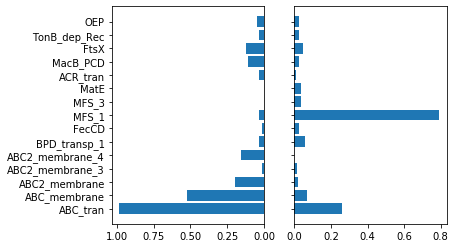

In [42]:
## Small vs large molecules
big = mibig_struct[mibig_struct.MW > 1500]
print(big.shape)
big_pfams = mibig_pfam[mibig_pfam.BGC.isin(big['BGC'])]
del big_pfams['Order']
del big_pfams['BGC']

small = mibig_struct[mibig_struct.MW < 500]
print(small.shape)
small_pfams = mibig_pfam[mibig_pfam.BGC.isin(small['BGC'])]
del small_pfams['Order']
del small_pfams['BGC']

fig, axes = plt.subplots(ncols=2, sharey=True)
axes[0].barh(big_pfams[cols].sum().keys(), 
             big_pfams[cols].astype(bool).sum() / big_pfams.shape[0], 
             align='center')

axes[1].barh(small_pfams[cols].sum().keys(), 
             small_pfams[cols].astype(bool).sum() / small_pfams.shape[0], 
             align='center')

axes[0].invert_xaxis()
plt.savefig("Fig2c.svg")

plt.show()

ABC_tran associated with MW 1.8802691194653424e-33


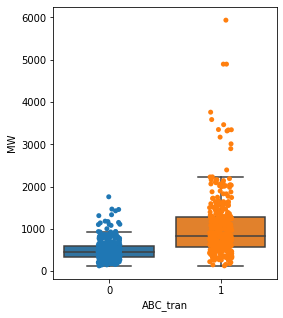

ABC_membrane associated with MW 2.8394927893339035e-12


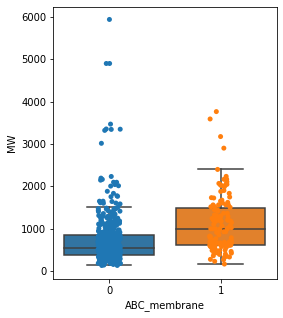

ABC2_membrane associated with MW 3.4935984881698973e-10


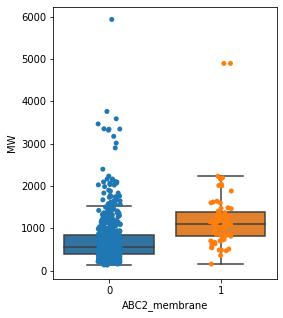

MFS_1 associated with MW 2.7738235938292785e-33


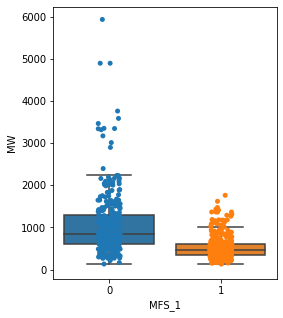

ABC2_membrane_4 associated with MW 6.6488248660893e-21


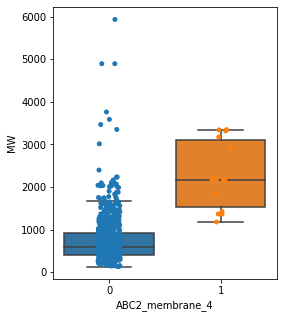

****
ABC_tran associated with LOGP 9.884518813149887e-07


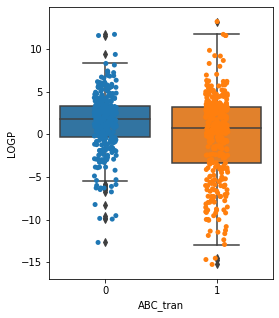

ABC_membrane associated with LOGP 5.500152811258541e-13


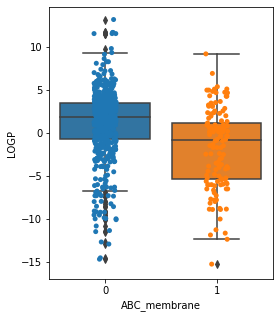

FecCD associated with LOGP 0.0018458325727451403


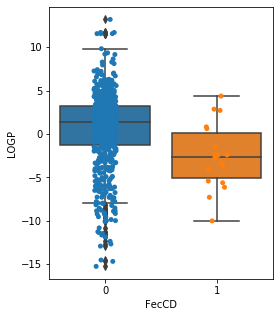

MFS_1 associated with LOGP 0.00010722058500818468


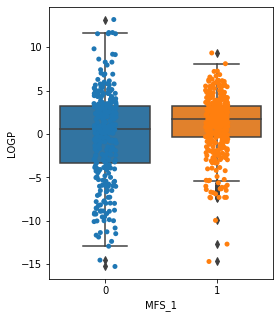

ABC2_membrane_3 associated with LOGP 0.0002966716186214049


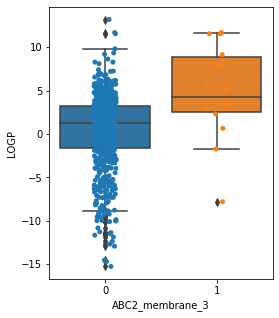

ABC2_membrane_4 associated with LOGP 2.5483898111756796e-09


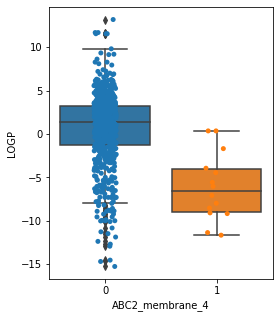

MMPL associated with LOGP 4.8896537563143346e-05


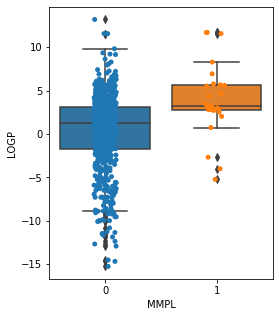

In [43]:
import statsmodels.formula.api as sm

domains = ['ABC_tran', 'BPD_transp_1',
       'TonB_dep_Rec', 'ABC_membrane', 'ACR_tran', 'FecCD', 'ABC2_membrane',
       'MatE', 'OEP', 'FtsX', 'MFS_3', 'MFS_1', 'ABC2_membrane_2',
       'ABC2_membrane_3', 'MacB_PCD', 'ABC2_membrane_4',
       'MMPL', 'BPD_transp_2', 'Multi_Drug_Res']

# sns.set_style('white')

pal = sns.color_palette('Paired')

for d in domains:
    merged_struct[d] = merged_struct[d].astype('bool').astype('int')
## Which PFAMs vary significantly with MW?
    form = "MW ~ " + d
    result = sm.ols(formula= form, data=merged_struct).fit()
    if result.pvalues[d] < 0.05 / len(domains):
        print(d + " associated with MW " + str(result.pvalues[d]))
        plt.rcParams["figure.figsize"] = (4,5)
        sns.stripplot(merged_struct[d], merged_struct['MW'])
        sns.boxplot(merged_struct[d], merged_struct['MW'], fliersize=0)
        plt.savefig(d + "_mw_boxplot.svg")
        plt.show()
print("****")
for d in domains:
    merged_struct[d] = merged_struct[d].astype('bool').astype('int')
## Which PFAMs vary significantly with LOGP?
    form = "LOGP ~ " + d
    result = sm.ols(formula= form, data=merged_struct).fit()
    if result.pvalues[d] < 0.05 / len(domains):
        print(d + " associated with LOGP " + str(result.pvalues[d]))
        sns.stripplot(merged_struct[d], merged_struct['LOGP'])
        sns.boxplot(merged_struct[d], merged_struct['LOGP'])
        plt.savefig(d + "_logp_boxplot.svg")
        plt.show()
        
pfam_domains = domains

In [119]:
### CATHDB associations

merged_cathdb = pd.merge(mibig_struct, mibig_cathdb, on='BGC')
domains = list(mibig_cathdb.columns[1:])

mw_associated = []
i = 0
for d in domains:
    i += 1
    merged_cathdb["d_" + str(i)] = merged_cathdb[d].astype('bool').astype('int')
## Which PFAMs vary significantly with MW?
    form = "MW ~ " + "d_" + str(i)
    result = sm.ols(formula= form, data=merged_cathdb).fit()
    if result.pvalues["d_" + str(i)] < 0.05 / len(domains):
        print(d + " associated with MW " + str(result.pvalues["d_" + str(i)]))
        print(cathdbs[cathdbs.FunFam == d]['Description'])
#         sns.boxplot(merged_cathdb[d], merged_cathdb['MW'])
#         sns.stripplot(merged_cathdb[d], merged_cathdb['MW'])
        
#         plt.show()
        mw_associated.append(d)
print("****")

logp_associated = []
for d in domains:
    merged_cathdb["d_" + str(i)] = merged_cathdb[d].astype('bool').astype('int')
## Which PFAMs vary significantly with MW?
    form = "LOGP ~ " + "d_" + str(i)
    result = sm.ols(formula= form, data=merged_cathdb).fit()
    if result.pvalues["d_" + str(i)] < 0.05 / len(domains):
        print(d + " associated with LOGP " + str(result.pvalues["d_" + str(i)]))
        print(cathdbs[cathdbs.FunFam == d]['Description'])        
#         sns.boxplot(merged_cathdb[d], merged_cathdb['LOGP'])
#         sns.stripplot(merged_cathdb[d], merged_cathdb['LOGP'])
        
#         plt.show()
        logp_associated.append(d)
        


/home/alexcc/.pyenv/versions/3.6.0/lib/python3.6/site-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/home/alexcc/.pyenv/versions/3.6.0/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/alexcc/.pyenv/versions/3.6.0/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/alexcc/.pyenv/versions/3.6.0/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


1.20.1250.20/FF/180940 associated with MW 8.43891973619124e-12
12    Drug resistance MFS transporter
Name: Description, dtype: object
3.40.50.300/FF/628823 associated with MW 4.559808661596993e-22
21    ABC transporter ATP-binding component
Name: Description, dtype: object
1.20.1560.10/FF/26651 associated with MW 3.516777677972678e-16
29    ABC transporter ATP-binding protein/permease
Name: Description, dtype: object
1.20.1250.20/FF/180267 associated with MW 6.778229214796941e-07
33    Drug resistance transporter, EmrB/QacA family
Name: Description, dtype: object
3.40.50.300/FF/635508 associated with MW 8.390810266122636e-09
35    ABC transporter ATP-binding protein
Name: Description, dtype: object
3.40.50.300/FF/627204 associated with MW 1.9731194361060706e-07
39    ABC transporter ATP-binding protein/permease
Name: Description, dtype: object
1.20.1250.20/FF/180270 associated with MW 0.00010816840273301034
44    Major facilitator superfamily transporter
Name: Description, dtype: objec

In [120]:
print(pd.Series(mw_associated)[pd.Series(mw_associated).isin(import_cathdbs)])
print(pd.Series(mw_associated)[pd.Series(mw_associated).isin(export_cathdbs)])

print(pd.Series(logp_associated)[pd.Series(logp_associated).isin(import_cathdbs)])
print(pd.Series(logp_associated)[pd.Series(logp_associated).isin(export_cathdbs)])

Series([], dtype: object)
8    3.40.50.300/FF/634340
9    3.40.50.300/FF/632705
dtype: object
Series([], dtype: object)
5    1.20.1640.10/FF/24590
7    3.40.50.300/FF/632705
dtype: object


## Formatted for ML here

In [128]:
merged_cathdb = pd.merge(mibig_struct, mibig_cathdb, on='BGC')


In [130]:
list(merged_cathdb.columns)

X = merged_cathdb[cathdbs['FunFam']].to_numpy()
y = merged_cathdb['MW'].to_numpy()
y2 = merged_cathdb['LOGP'].to_numpy()